**INTRODUCTION**

The Histopathologic Cancer Detection project involved a data set of lymph node sections. The goal is to identify and label whether the images show metastatic tissue indicative of canerous cells.  A convolutional neural network model will be developed and evaluated based on a training data set of 220,025 images with labels indicating if they display cancerous cells. Then, the model is used to predict the outcomes of 57,458 testing images. 

**Exploratory Analysis and Data Preparation**

After importing the necessary libraries and loading the data, a couple types of exporatory analysis were conducted. First, a breif look at some images and their corresponding label shows a range of cells. My domain understanding of what a cancerous cell looks like is non-existant, so this element gave a sense of what the images look like and their coloring.

The next step was a look at the break down of the number of cancerous and non-cancerous labels. The 60-40 non-cancerous/cancerous split is slightly off even but not so much as to necessitate any sampling to even out the breakdown.

Finally, a new data set was prepared which will have more complete filenames for easier use in the creation of the model. The Keras library was used to rescale our data into specific color spectrum integers (0-255) and then split our training data into training (176,020 images) and validation sets (44,005). 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

import os

directory = '/kaggle/input/histopathologic-cancer-detection/'

train_df = pd.read_csv(directory + 'train_labels.csv')
train_df.head()

2024-03-06 22:38:59.680949: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-06 22:38:59.681090: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-06 22:38:59.881910: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


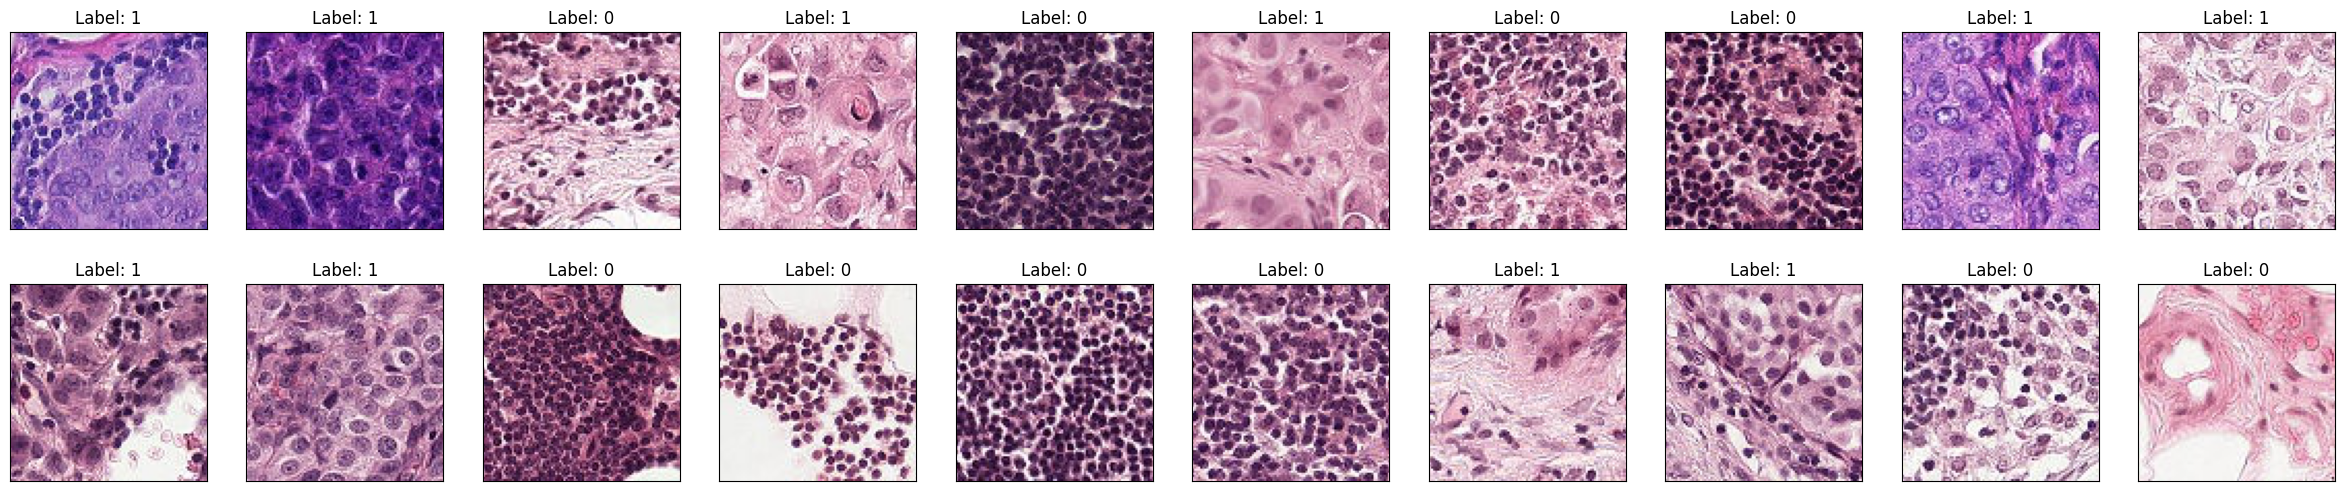

In [2]:
fig = plt.figure(figsize=(30, 6))
train_imgs = os.listdir(directory+"train")
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open(directory+"train/" + img)
    plt.imshow(im)
    label = train_df.loc[train_df['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title(f'Label: {label}')

In [3]:
test_imgs = os.listdir(directory+"test")

<Axes: ylabel='count'>

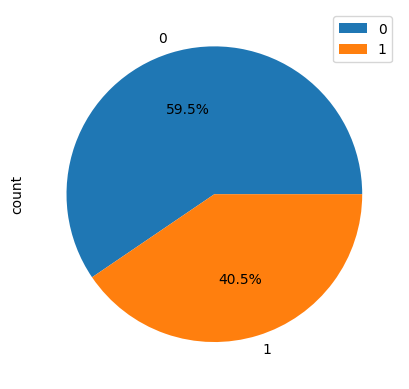

In [4]:
train_df['label'].value_counts().plot(kind='pie', legend=True, autopct='%1.1f%%')

In [5]:
train_df['label'].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

In [6]:
def make_train_path(id_str):
    return os.path.join(directory+'train', f"{id_str}.tif")

In [7]:
train_df["filename"] = train_df["id"].apply(make_train_path)
train_df["label"] = train_df["label"].astype(str)
train_df.head()

,id,label,filename
0,f38a6374c348f90b587e046aac6079959adf3835,0,/kaggle/input/histopathologic-cancer-detection...
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,/kaggle/input/histopathologic-cancer-detection...
2,755db6279dae599ebb4d39a9123cce439965282d,0,/kaggle/input/histopathologic-cancer-detection...
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,/kaggle/input/histopathologic-cancer-detection...
4,068aba587a4950175d04c680d38943fd488d6a9d,0,/kaggle/input/histopathologic-cancer-detection...


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator(rescale=1/255, validation_split=0.2)

train_data = data_gen.flow_from_dataframe(dataframe=train_df,
    x_col="filename",y_col="label",target_size=(96, 96),batch_size=32,
    class_mode="binary",subset="training")

val_data = data_gen.flow_from_dataframe(dataframe=train_df,
    x_col="filename",y_col="label",target_size=(96, 96),color_mode="rgb",
    batch_size=32,class_mode="binary",subset="validation")

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


**Model Training and Creation**

Two models were created and their performance compared. Each had similar constructions and architectures with the second model having a deeper net of nodes and filters. The input layer receives each imput image and represents it as a 3-D tensor with dimensions (96,96,3) corresponding to the pixel size of the image and the 3 color channels.  Each convolutional layer scans the image with a kernel of a smaller size which helps detect patterns within the imput image. The activation layer further illuminates these complex patterns and relationships. Pooling layers reduce spacial dimensions producted by the convolutional layers in order to help prevent overfitting.

Each additional convolutional layer increases the ability to recognize patterns. The second model includes dropout layers to add robustness and Dense layers allowing for non-linear combinations of features to be learned.

For each, 5 epochs were run. While not large, the time to run each was considerate (approzimately 20 mins) probably due to the size of the imput data. However, the accuracy of each did begin to asymptotically converge indicating tha the model was learning through each epoch and that the learning started to slow to a point where the diminishing returns of each additional epoch were clear.

Each model utilized an Adam optimizer when compling. The Adam optimizer automatically adapts the learning rate during the training process which leads to fast convergence. Since the model results in binary classification, sparse categorical crossentropy was a good choice for the loss function. 


In [10]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

model = tf.keras.Sequential()
model.add(layers.Rescaling(1./255, input_shape=(96,96,3)))
model.add(layers.Conv2D(32, (2, 2), strides=(2,2), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (2, 2), strides=(2,2), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 12, 12, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       589,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 599,210 (2.29 MB)

 Trainable params: 599,210 (2.29 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
test_path = directory + "test"
test_ids = [filename[:-4] for filename in os.listdir(test_path)]
test_filenames = [os.path.join(test_path, filename) for filename in os.listdir(test_path)]
test_df = pd.DataFrame()
test_df["id"] = test_ids
test_df["filename"] = test_filenames

test_data = data_gen.flow_from_dataframe(dataframe=test_df,
    x_col="filename",y_col=None,target_size=(96, 96),color_mode="rgb",batch_size=64,
    shuffle=False,class_mode=None)

Found 57458 validated image filenames.


In [15]:
conv_train_res = model.fit(train_data, validation_data = val_data, 
                           epochs = 5)


Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1820s 330ms/step - accuracy: 0.5925 - loss: 0.6871 - val_accuracy: 0.6185 - val_loss: 0.6238
Epoch 2/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 686s 125ms/step - accuracy: 0.6084 - loss: 0.6302 - val_accuracy: 0.5963 - val_loss: 0.6258
Epoch 3/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 503s 81ms/step - accuracy: 0.6099 - loss: 0.6260 - val_accuracy: 0.6235 - val_loss: 0.6191
Epoch 4/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 502s 81ms/step - accuracy: 0.6124 - loss: 0.6218 - val_accuracy: 0.6252 - val_loss: 0.6182
Epoch 5/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 500s 81ms/step - accuracy: 0.6113 - loss: 0.6226 - val_accuracy: 0.6037 - val_loss: 0.6172


In [16]:
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
model2.add(MaxPooling2D((2, 2)))
model2.add(Dropout(0.5))
model2.add(Conv2D(32, (3, 3), activation='relu'))
model2.add(MaxPooling2D((2, 2)))
model2.add(Dropout(0.5))
model2.add(Flatten())
model2.add(Dense(128, activation="relu"))
model2.add(Dropout(0.5))
model2.add(Dense(10))

model2.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 45, 45, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 15488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,982,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,994,026 (7.61 MB)

 Trainable params: 1,994,026 (7.61 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
conv_train_2 = model2.fit(train_data, validation_data = val_data, epochs = 5)

Epoch 1/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1219s 221ms/step - accuracy: 0.7628 - loss: 0.5127 - val_accuracy: 0.8009 - val_loss: 0.4931
Epoch 2/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1256s 228ms/step - accuracy: 0.8296 - loss: 0.3970 - val_accuracy: 0.7856 - val_loss: 0.4886
Epoch 3/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1273s 227ms/step - accuracy: 0.8415 - loss: 0.3747 - val_accuracy: 0.8344 - val_loss: 0.4175
Epoch 4/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1297s 229ms/step - accuracy: 0.8460 - loss: 0.3626 - val_accuracy: 0.8105 - val_loss: 0.4273
Epoch 5/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1254s 228ms/step - accuracy: 0.8499 - loss: 0.3565 - val_accuracy: 0.8443 - val_loss: 0.4002


**Model Performance and Analysis**

Unsurprisingly, the more robust model (model 2) demonstarted noticeably higher accouracy in both the training and validation sets. Model 1 ranged from 59% to 61% training accuracy and 59%-62% training. The consistency of these accuracy numbers indicate minimal overfitting to the training set.  Model 2 had accuracy ranges of 76%-85% for the training set and 80%-84% for the validation. Model 2 demonstrated a stronger ability to learn from epoch to epoch and accounded for any resulting overfitting well.

Model 2 also demonstrated better loss values as well.

In [21]:
yhat = model2.predict(test_data)

898/898 ━━━━━━━━━━━━━━━━━━━━ 544s 606ms/step


In [34]:
predicted_labels = np.argmax(yhat, axis=1)

array([0, 0, 0, ..., 1, 0, 0])

In [55]:
predDic = {
    "id" : test_df['id'],
    "label" : predicted_labels}

preds = pd.DataFrame(predDic)



In [58]:
preds.to_csv("./cancer_preds.csv", index=False)

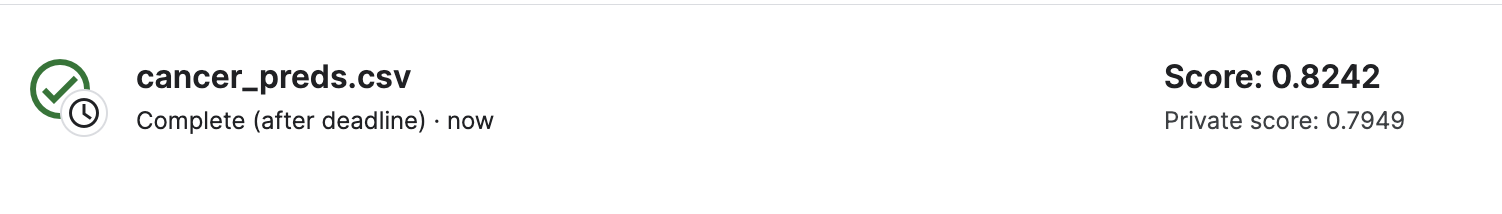

**Conclusion and Recommendation**

Overall, this project was quite challenging and I learned a lot. The submission to Kaggle resulted in a score of 0.8242.  Given the difficulty involved, I feel pretty proud of this results.

The biggest change I will need to make going forward is finding a way to make the model run faster. I used Kaggle's notebook feature which allowed for easier importing of the large dataset but ultimately did inhibit the speed in which my model could run.  Using a GPU in the future would allow for a much faster experience.


**Sources**

Predicting Images with a CNN, https://medium.com/@msgold/predicting-images-with-a-cnn-90a25a9e4509

Tensor Flow Image Classification, https://www.tensorflow.org/tutorials/images/classification